Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

Do not remove any cell from the notebook you downloaded. If you need you can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

Fill in your name and id number (numero matricola) below:

In [32]:
NAME = "Giulio Savian"
ID_number = int("1167313")

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# HOMEWORK #4
Unsupervised learning
In this notebook we are going to explore the use of unsupervised clustering methods.

In [33]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs

In [34]:
# TODO 1: Write a function to compute the pdf of a gaussian random vector, you just need to apply its definition.

def gv_normalizing_const(sigma : np.ndarray) -> np.float64:
    '''
    Function to compute the normalization coefficient of a vector valued Gaussian distribution.
    :param sigma: Covariance of the Gaussian random vector (d x d Positive Definite matrix). 
    '''
    # YOUR CODE HERE
    normalizing_const = 1 / (np.linalg.det(2 * np.pi*sigma)) ** 0.5
    return normalizing_const

def gaussian_pdf(x : np.ndarray, mu : np.ndarray, sigma : np.ndarray) -> np.ndarray:
    '''
    Function to compute the pdf of a vector valued gaussian distribution on the location x given its parameters: 
    mu and sigma. We are assuming sigma is invertible (you do not need to check its invertibility). For simplicity
    return the pdf with shape (1,1), this should be the shape you get after the quadratic form computation. 
    '''
    # YOUR CODE HERE
    unnomrmalized_pdf =  np.exp( - (0.5 * (x - mu).T.dot(np.linalg.inv(sigma)).dot((x - mu))))
    return gv_normalizing_const(sigma) * unnomrmalized_pdf

In [35]:
assert type(gv_normalizing_const(np.array([[2.]]))) == np.float64
# Test on scalar case
x = np.array([[1.]])
mean, cov = np.array([[2.5]]), np.array([[0.5]])
assert np.isclose(multivariate_normal.pdf(1, mean=mean, cov=cov), gaussian_pdf(x, mean, cov), atol=1e-3)

# Test on vector valued case
mean, temp = np.random.normal(2, 3, 2).reshape(-1,1), np.random.normal(2, 3, 4).reshape(2,2)
x = np.random.normal(2, 3, 2).reshape(-1,1)
cov = temp @ temp.T
hand_pdf = gaussian_pdf(x, mean, cov)
scipy_pdf = multivariate_normal.pdf(x.reshape(1,-1)[0], mean.reshape(1,-1)[0], cov)
assert np.isclose(hand_pdf, scipy_pdf, atol=1e-4)


Let's load a 1-D dataset which does not contain any label. It has been generated using K clusters. Can you tell 
how many clusters have been used by looking at the scatter plot?

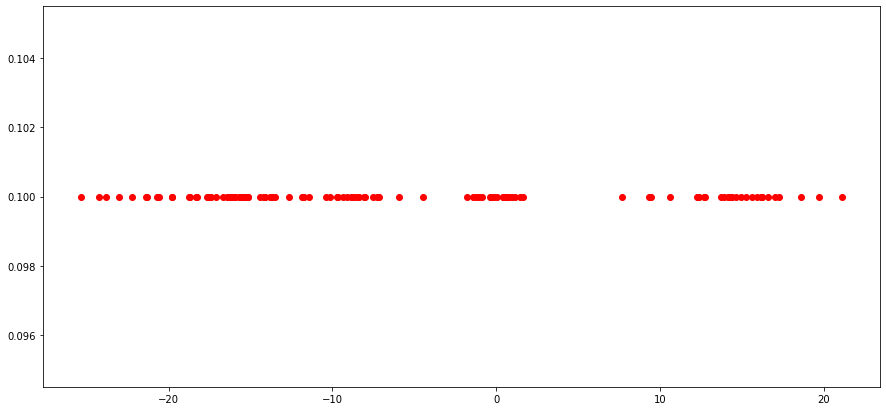

In [36]:
url = 'https://raw.githubusercontent.com/LucaZancato/ML2020-2021/main/HW_4/1_D_dataset.csv'
data = np.array(pd.read_csv(url, sep=';'))

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color='r')

It's not trivial to judge how many clusters are present. Such an issue is present also in the case of EM on GMM (the one we are going to implement) and Kmeans: for both of these algorithms the number of clusters is fixed a priori, it is a parameter (hyper-parameter) we must decide before processing any datum.
Usually in order to achieve satisfactory clustering one needs to try with different number of classes and validate which is the best number. 

For now let's make it simple and let's consider the dataset has 3 clusters. 
In the following cell we shall parametrize 3 Gaussian random variables specifiying both means, covariances and mixing probabilities. Take a second to understand the way these parameters are stored, since the EM implementation is built on this notation. For now, means, cov and mixing probabilities are choosen without any specific criterion, we will see how EM applied to GMM will provide us a suboptimal set of means, covariances and mixing probabilities.

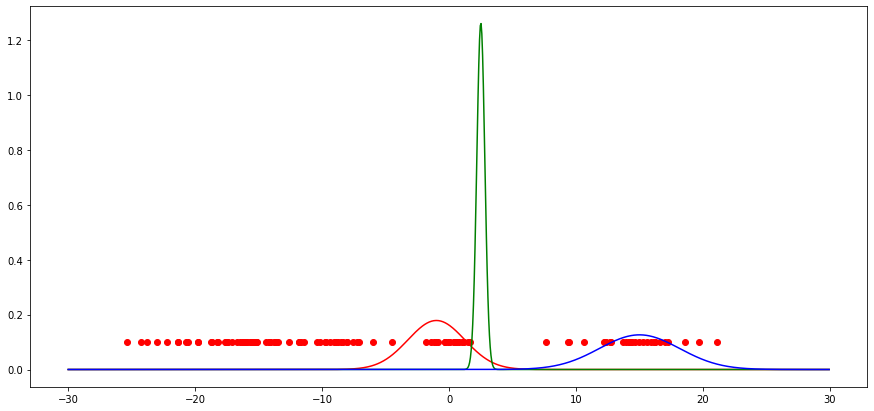

In [37]:
means = np.array([[-1],[2.5],[15]])      # KxF
covs  = np.array([[[5]],[[0.1]],[[10]]]) # KxFxF 
pi    = np.array([[1/2],[1/4],[1/4]])    # Kx1

X = np.linspace(-30, 30, 1000, endpoint=False).reshape(-1,1)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color='r')
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

In [38]:
# TODO 2: Write a function M_step which computes the M-step of the EM algorithm in case of a GMM. Refer 
# to the slides you can find on the moodle (in which ALL the necessary steps and expressions are present).
# Start by looking at the function "M_step" and then build all the help functions.

def update_pi(W : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    new_pi= W.sum(axis=0)/len(W)
    return new_pi

def update_means(data : np.ndarray, W : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE
    new_means = np.dot(data.T,W)
    new_means = new_means/W.sum(axis=0)
    return new_means.T

def update_covs(data : np.ndarray, W : np.ndarray, new_means : np.ndarray) -> np.ndarray:
    '''
    See M_step docs.
    '''
    # YOUR CODE HERE

    m = W.shape[0]                                                #Number of data
    clusters = W.shape[1]                                         #Number of clusters
    features = data.shape[1]                                      #Features of data
    new_covs = np.zeros((clusters, features, features))           #Inizializzo new_covs 
    #COMPUTE new_covs:
    for j in range(clusters):
      for i in range(m):
        ys = np.reshape(data[i] - new_means[j], (features,1))
        new_covs[j] += W[i,j] * np.dot(ys, ys.T)
      new_covs[j] /= W[:,j].sum()                                  
    return  new_covs 

def M_step(data : np.ndarray, W : np.ndarray) -> tuple:
    '''
    Function to compute the Maximization step on a GMM model (use the expressions derived on the slides).
    :param data: Dataset N x d (d := number of features)
    :param W: Weight matrix N x K (K :=number of classes). Element in position (i,j) represents the probability of
              i-th datum to belong to class j (j-th cluster) given the current parameters: pi, means, covs
    :returns: (new_pi, new_mu, new_cov)
        WHERE:
        new_pi: Contains the mixing probabilities. Its shape is (K,)
        new_mu: Contains the new means of the GMM model. Its shape is (K, d)
        new_cov: Contains the new covariances of the GMM model. Its shape is (K, d, d)
    '''
    new_pi    = update_pi(W)
    new_means = update_means(data, W)
    new_covs  = update_covs(data, W, new_means)
    
    return new_pi, new_means, new_covs 

In [39]:
W = np.array([[0.5, 0.5, 0],[0.5, 0, 0.5]])
assert np.isclose(update_pi(W), [0.5 , 0.25, 0.25], atol=1e-4).all()
W = np.random.normal(0,1, 1000).reshape(-1, 25) # Note this W is not normalized properly, we do not care not since we are testing only the output shape is correct
assert update_pi(W).shape == (25,)
# Test on the means update function
a = np.random.normal(0,1, 80).reshape(-1, 2)
b = update_means(a, W)
assert b.shape  == (25, 2)
# Test on the covs update function
assert update_covs(a, W, b).shape == (25, 2, 2)


In [40]:
# TODO 3: Write a function E_step which computes the E-step of the EM algorithm in case of a GMM. Refer 
# to the slides you can find on the moodle (in which ALL the necessary steps and expressions are present).
def E_step(data : np.ndarray, pi : np.ndarray, means : np.ndarray, covs : np.ndarray):
    '''
    Function to compute the Expectation step on a GMM model (use the expressions derived on the slides) given 
    the current values of the GMM parameters: pi, means, covs.
    :param data:  Same as M_step function.
    :param pi:    Same as M_step function.
    :param means: Same as M_step function.
    :param covs:  Same as M_step function.
    :returns: W, which is updated using the parameters of the GMM: pi, means, covs. W must be normalized (see 
              slides)
    '''
    # YOUR CODE HERE
    m,p = data.shape
    k = len(pi)
    W = np.zeros((k, m)) #Inizialize the matrix
    
    # COMPUTE W:
    for j in range(len(means)):
      for i in range(m):
        W[j, i] = gaussian_pdf(data[i],means[j,:], covs[j,:,:]) * pi[j]
    W /= W.sum(0) 

    return W.T

In [41]:
assert E_step(data, pi, means, covs).shape == (119, 3)
assert np.isclose(np.sum(E_step(data, pi, means, covs).sum(1) - 1), 0, atol=1e-4)

In [42]:
# TODO 4: Write a function to randomly initialize the parameters of a GMM. This is necessary to start with the 
# EM iterations. 

def randomly_initialize_W(data : np.ndarray, num_classes : int) -> np.ndarray:
    '''
    See random_init function docs.
    '''
    # YOUR CODE HERE
    m = data.shape[0]
    clusters = m // num_classes
    r = m % num_classes            #rest
    count = 0

    W = np.zeros((m,num_classes))  #inizialize W
    index = np.random.choice(range(m) , m , replace=False) #used for select ramdomly all the data
    for l in range(num_classes - 1):
      for j in range(clusters):
        i = index[count]
        W[i,l] = 1
        count +=1
    
    l = num_classes - 1           #loop for the last data
    for j in range(clusters + r):
      i = index[count]
      W[i,l] = 1
      count += 1
    return W

def random_init(data : np.ndarray, num_classes : int) -> np.ndarray:
    '''
    Function to initialize W and GMM parameters. W is generated assigning randomly each datapoint only to one 
    cluster. We require to assign the same number of points for each cluster (even this is not striclty necessary
    to run the EM algorithm on GMM). If the number of data is not exactly divisible by the number of clusters 
    assign the exceeding data to one single class (it does not matter which one). 
    See M_step docs for details on W, interpretation and required shape.
    '''
    # Initialize W
    W = randomly_initialize_W(data, num_classes)
    # Use M_step to get GMM parameters
    pi, means, covs = M_step(data, W)
    return W, pi, means, covs

In [43]:
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,10), 5).sum(0) == 2).all()
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,5), 2).sum(0) == 10).all()
assert (randomly_initialize_W(np.random.normal(0,1, 100).reshape(-1,5), 3).sum(0) -6 == 2).any()

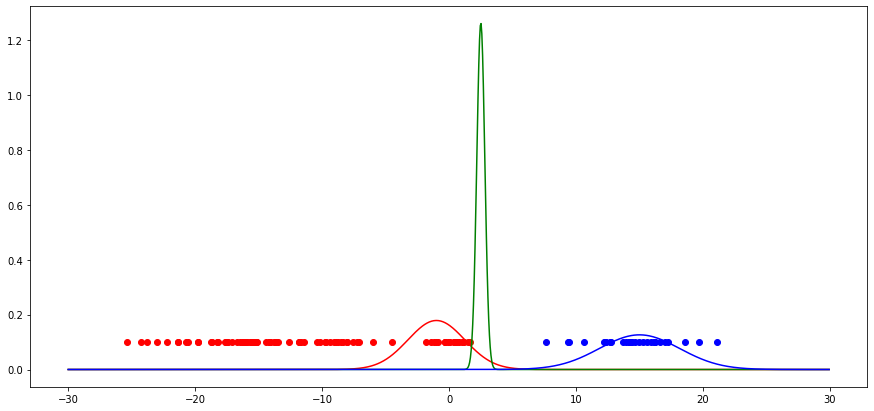

In [44]:
# Let's evaluate the class probability of each datum given current pi, means and covs. 
# Since we have 3 clusters we shall color code (rgb) each datum according to the class probabilities.t
W = E_step(data, pi, means, covs)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color=np.array([W[i][0], W[i][1], W[i][2]]))
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

In [45]:
# TODO 5: compute the log likelihood of an iid dataset under a GMM model.
def log_likelihood_GMM(data : np.ndarray, pi : np.ndarray, means : np.ndarray, covs : np.ndarray) -> float:
    '''
    Function to compute the log likelihood for a set of iid observations under a GMM. Use the function you built
    before "gaussian_pdf" to compute the likelihood. 
    :param data: N x d matrix containing a set of N iid data of dimension d
    :param pi:    Same as M_step function.
    :param means: Same as M_step function.
    :param covs:  Same as M_step function.
    '''
    # YOUR CODE HERE

    m,p = data.shape
    k = len(pi)
    gau = np.zeros((k, m))
    log_likelihood = 0     #Inizialize log_likelihood
    # COMPUTE log_likelihood:
    for i in range(m): #iterate on data
      s = 0
      for j in range(k): #itearate on clusters
        s += pi[j] * gaussian_pdf(data[i,:], means[j,:], covs[j,:,:])
      log_likelihood += np.log(s)

    return np.float64(log_likelihood)

In [46]:
assert type(log_likelihood_GMM(data, pi, means, covs)) == np.float64

Iteration 0, log likelihood -473.0223,  delta log likelihood 0.2382
Iteration 1, log likelihood -472.7469,  delta log likelihood 0.2754
Iteration 2, log likelihood -472.2276,  delta log likelihood 0.5193
Iteration 3, log likelihood -471.1494,  delta log likelihood 1.0782
Iteration 4, log likelihood -468.8812,  delta log likelihood 2.2683
Iteration 5, log likelihood -464.9663,  delta log likelihood 3.9149
Iteration 6, log likelihood -460.5851,  delta log likelihood 4.3811
Iteration 7, log likelihood -456.7537,  delta log likelihood 3.8314
Iteration 8, log likelihood -454.1681,  delta log likelihood 2.5856
Iteration 9, log likelihood -453.0623,  delta log likelihood 1.1058
Iteration 10, log likelihood -452.6498,  delta log likelihood 0.4125
Iteration 11, log likelihood -452.4454,  delta log likelihood 0.2045
Iteration 12, log likelihood -452.3054,  delta log likelihood 0.1399
Iteration 13, log likelihood -452.1917,  delta log likelihood 0.1137
Iteration 14, log likelihood -452.0937,  del

Text(0, 0.5, 'Log likelihood')

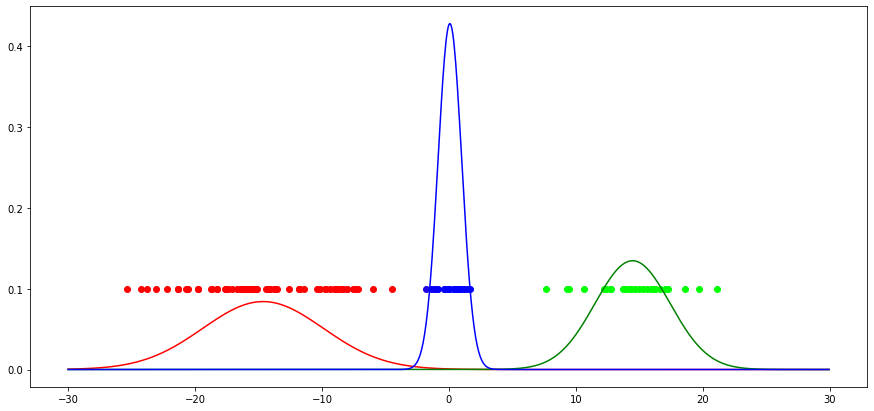

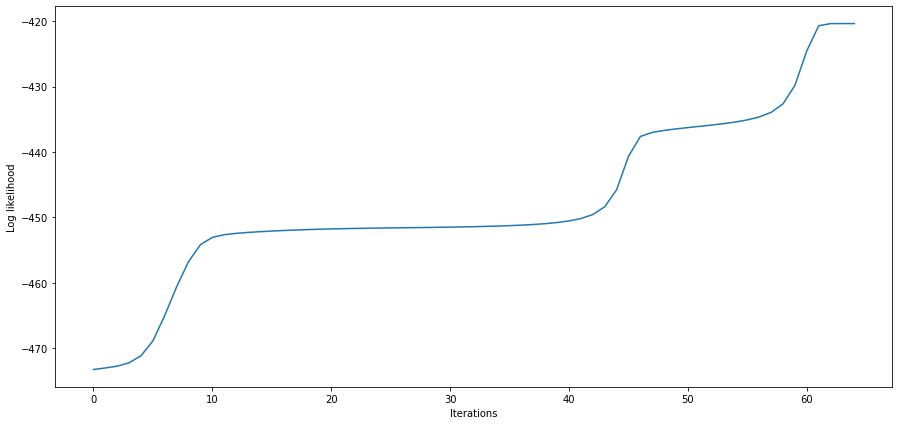

In [47]:
# TODO 6: Write a function to run the EM on GMM using the building blocks we created so far. Then test it on the 
# data we used so far (choose a meaningful max_iter, you do not need to exceed). 
def run_EM_on_GMM(data : np.ndarray, number_clusters : int, max_iter : int, epsilon : float = 1e-3,
                  plot_intermediate : bool = False) -> tuple:
    '''
    Function to run GMM on a given dataset and a given number of clusters. The termination conditions of the 
    iterative algorithm take into account either a specified max number of iterations or the improvement of the 
    log likelihood (if the log likelihood does not improve more than epsilon in two successive iterations we stop).
    :param data: N x d matrix containing a set of N iid data of dimension d
    :param number_clusters: # of clusters (information we have a priori, before starting the EM)
    :param max_iter: Maximum number of iterations allowed to the EM.
    :param epsilon: Threshold on the improvement of the log likelihood
    :param plot_intermediate: Boolean used to plot intermediate GMM for 2-d datasets (you do not need to implement
                              anything).
    :returns: (W, pi, means, covs, log_likelihood_train)
        WHERE:
        W:     Optimal W     after EM reaches termination condition (same shape as M_step function).
        pi:    Optimal pi    after EM reaches termination condition (same shape as M_step function).
        means: Optimal means after EM reaches termination condition (same shape as M_step function).
        covs:  Optimal covs  after EM reaches termination condition (same shape as M_step function).
        log_likelihood_train: log likelihoods obtained during training (saved using a list). 
    '''
    W, pi, means, covs = random_init(data, number_clusters)
    log_likelihood_train = [log_likelihood_GMM(data, pi, means, covs)]
    num_iter = 0
    # Used to plot 2-d data
    if plot_intermediate:
        x_max = np.max(np.abs(X))
        x, y = np.mgrid[-x_max:x_max:.05, -x_max:x_max:.05]
        pos = np.dstack((x, y))
    
    while (True): 
        # Iterate with E-Step and M-step
        # YOUR CODE HERE
        W = E_step(data, pi, means, covs)
        pi, means, covs = M_step(data, W) 

        # Save log likelihood given current GMM parameters
        log_likelihood_train.append(log_likelihood_GMM(data, pi, means, covs)) 

        if plot_intermediate:
            # Plot scatter plot of training data and corresponding clusters    
            fig = plt.figure(figsize=(15,7))
            for k in range(0, number_clusters):
                plt.contour(x, y, multivariate_normal(means[k], covs[k]).pdf(pos))
            plt.scatter(data[0:,0], data[0:,1])
            plt.title(f'Iteration {num_iter}')
        
        print(f'Iteration {num_iter}, log likelihood {log_likelihood_train[-1]:.4f}, ' 
              f' delta log likelihood {(log_likelihood_train[-1] - log_likelihood_train[-2]):.4f}')
        num_iter += 1 
        
        # Use proper termination conditions, on: number of iteration or log likelihood improvement (use the 
        # break statement to stop while cycle)
        # YOUR CODE HERE
        if  ((num_iter >= max_iter) or (np.abs(log_likelihood_train[num_iter] - log_likelihood_train[num_iter-1])) <= epsilon) :
          break
        
    return W, pi, means, covs, log_likelihood_train

# Let's try our implementation of the EM algorithm
max_iter = None
# YOUR CODE HERE
max_iter = 100
W, pi, means, covs, log_likelihood_train = run_EM_on_GMM(data, 3, max_iter, plot_intermediate=False)

plt.figure(figsize=(15,7))
for i, x in enumerate(data):
    plt.scatter(x, 0.1, color=np.array([W[i][0], W[i][1], W[i][2]]))
plt.plot(X, [gaussian_pdf(x, means[0], covs[0]) for x in X], color='r')
plt.plot(X, [gaussian_pdf(x, means[1], covs[1]) for x in X], color='g')
plt.plot(X, [gaussian_pdf(x, means[2], covs[2]) for x in X], color='b')

plt.figure(figsize=(15,7))
plt.plot(log_likelihood_train)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

In [48]:
a, b, c, d, e = run_EM_on_GMM(data, 3, 10, plot_intermediate=False)
assert a.shape == (119, 3)
assert b.shape == (3,)
assert c.shape == (3, 1)
assert d.shape == (3, 1, 1)

Iteration 0, log likelihood -473.0384,  delta log likelihood 0.2160
Iteration 1, log likelihood -472.8284,  delta log likelihood 0.2100
Iteration 2, log likelihood -472.4590,  delta log likelihood 0.3694
Iteration 3, log likelihood -471.7229,  delta log likelihood 0.7361
Iteration 4, log likelihood -470.1578,  delta log likelihood 1.5651
Iteration 5, log likelihood -467.0509,  delta log likelihood 3.1069
Iteration 6, log likelihood -462.6887,  delta log likelihood 4.3621
Iteration 7, log likelihood -458.4984,  delta log likelihood 4.1903
Iteration 8, log likelihood -455.1529,  delta log likelihood 3.3456
Iteration 9, log likelihood -453.3763,  delta log likelihood 1.7766


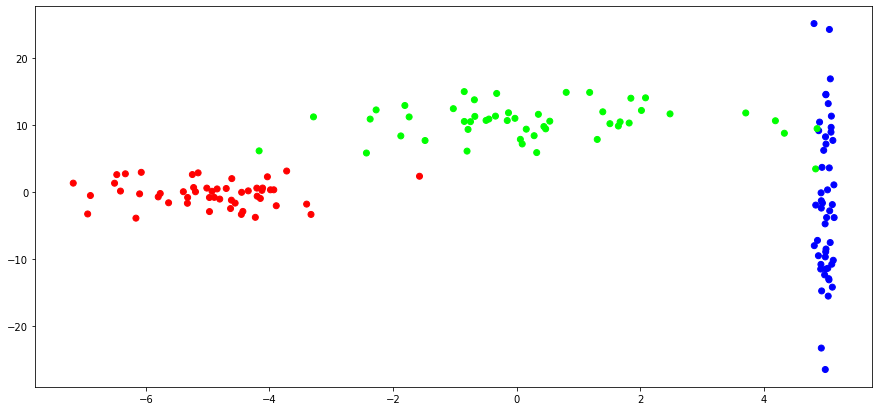

In [49]:
# We shall now use a 2-D dataset.
K = 3
clusters_cov = [[1,2], [2,3], [0.1,10]]
centers = [[-5, 0], [0, 10.5], [5, -1]]
X, Y = make_blobs(cluster_std=clusters_cov, centers=centers, random_state=ID_number, n_samples=150, shuffle=True)

colormap = np.array(['red', 'lime', 'blue'])

plt.figure(figsize=(15,7))
plt.scatter(X[:,0], X[:,1], c = colormap[Y])

Iteration 0, log likelihood -956.7946,  delta log likelihood 7.0595
Iteration 1, log likelihood -942.3695,  delta log likelihood 14.4251
Iteration 2, log likelihood -925.8908,  delta log likelihood 16.4788
Iteration 3, log likelihood -910.8835,  delta log likelihood 15.0072
Iteration 4, log likelihood -890.3716,  delta log likelihood 20.5120
Iteration 5, log likelihood -857.2290,  delta log likelihood 33.1426
Iteration 6, log likelihood -797.3268,  delta log likelihood 59.9022
Iteration 7, log likelihood -759.3093,  delta log likelihood 38.0175
Iteration 8, log likelihood -741.0156,  delta log likelihood 18.2937
Iteration 9, log likelihood -737.4701,  delta log likelihood 3.5455
Iteration 10, log likelihood -733.9656,  delta log likelihood 3.5045
Iteration 11, log likelihood -730.8315,  delta log likelihood 3.1341
Iteration 12, log likelihood -728.4277,  delta log likelihood 2.4038
Iteration 13, log likelihood -726.4903,  delta log likelihood 1.9374
Iteration 14, log likelihood -724.98

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Iteration 20, log likelihood -723.1150,  delta log likelihood 0.1025
Iteration 21, log likelihood -722.9367,  delta log likelihood 0.1783
Iteration 22, log likelihood -722.5702,  delta log likelihood 0.3665
Iteration 23, log likelihood -721.7347,  delta log likelihood 0.8355
Iteration 24, log likelihood -719.9093,  delta log likelihood 1.8254
Iteration 25, log likelihood -716.7389,  delta log likelihood 3.1704
Iteration 26, log likelihood -712.3025,  delta log likelihood 4.4364
Iteration 27, log likelihood -706.4955,  delta log likelihood 5.8070
Iteration 28, log likelihood -699.0911,  delta log likelihood 7.4044
Iteration 29, log likelihood -692.2045,  delta log likelihood 6.8866
Iteration 30, log likelihood -690.1485,  delta log likelihood 2.0560
Iteration 31, log likelihood -689.5425,  delta log likelihood 0.6060
Iteration 32, log likelihood -689.2508,  delta log likelihood 0.2917
Iteration 33, log likelihood -689.0287,  delta log likelihood 0.2221
Iteration 34, log likelihood -688.

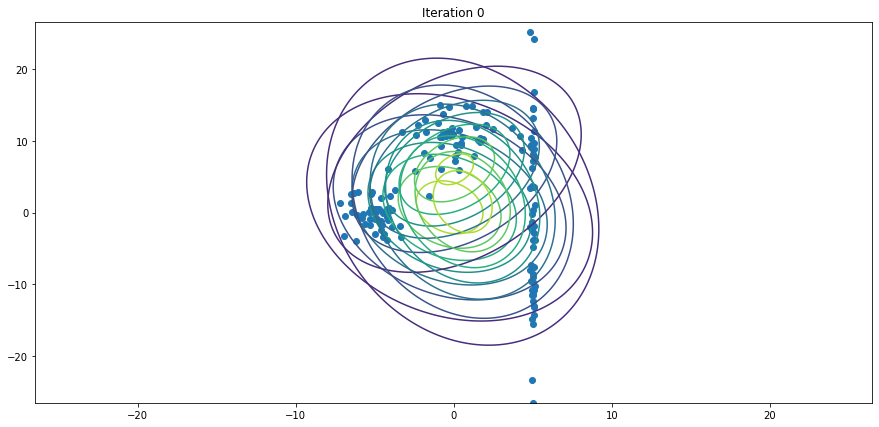

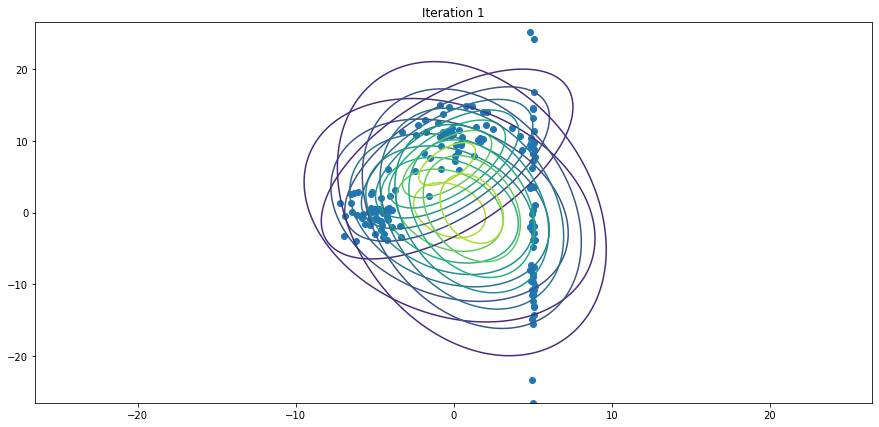

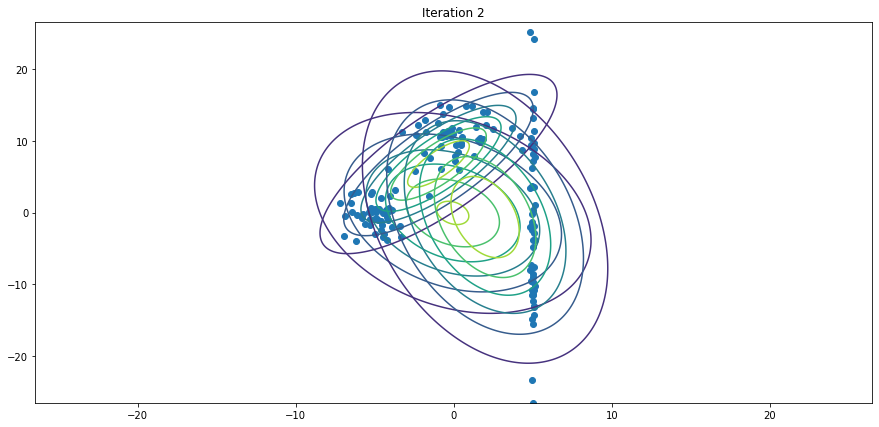

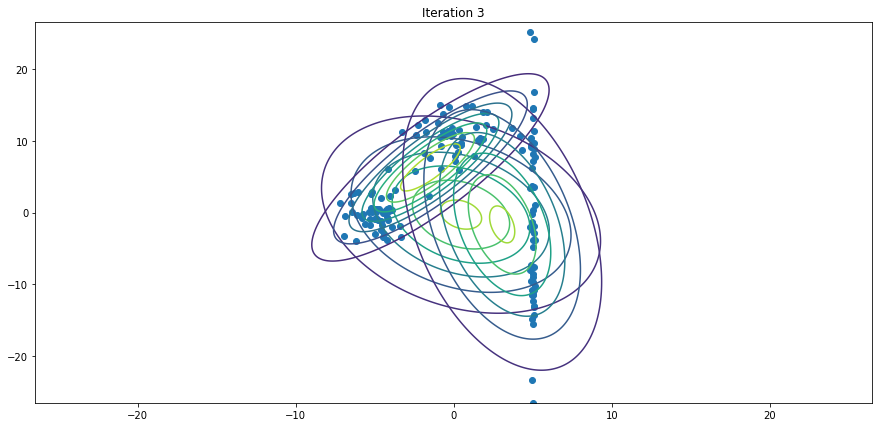

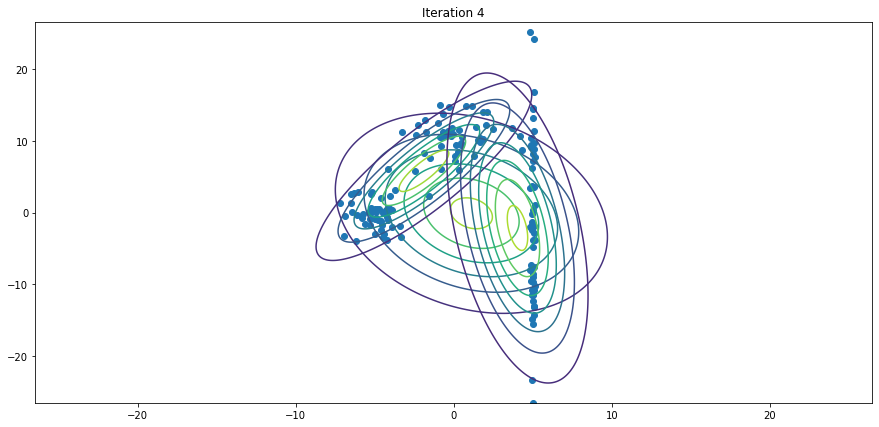

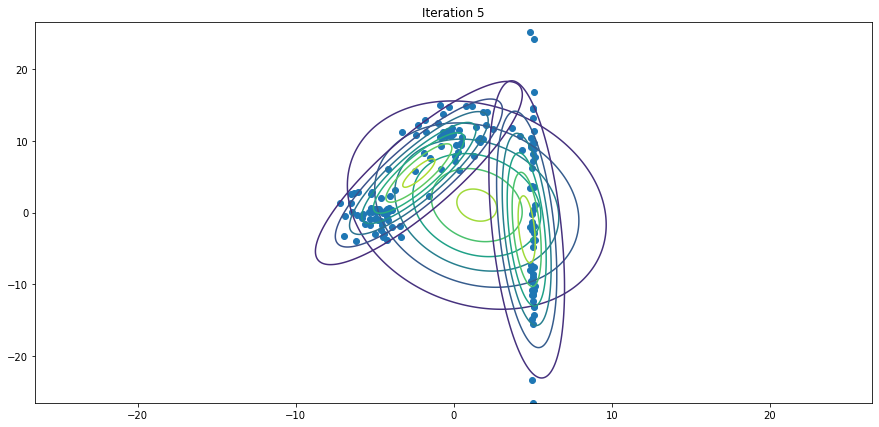

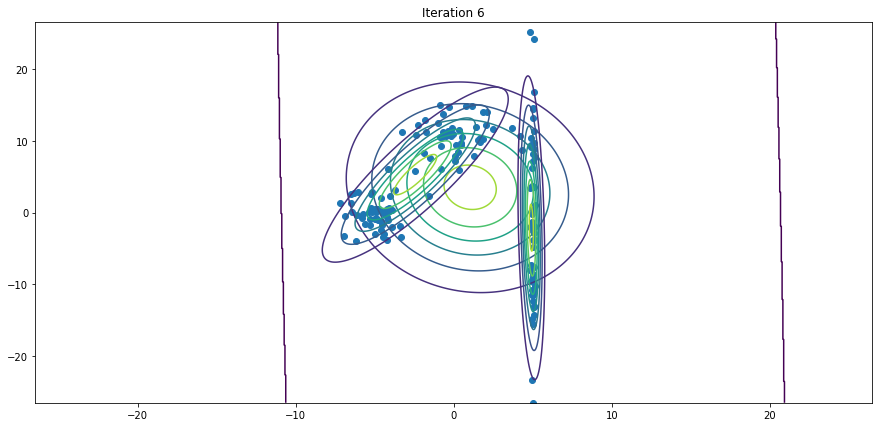

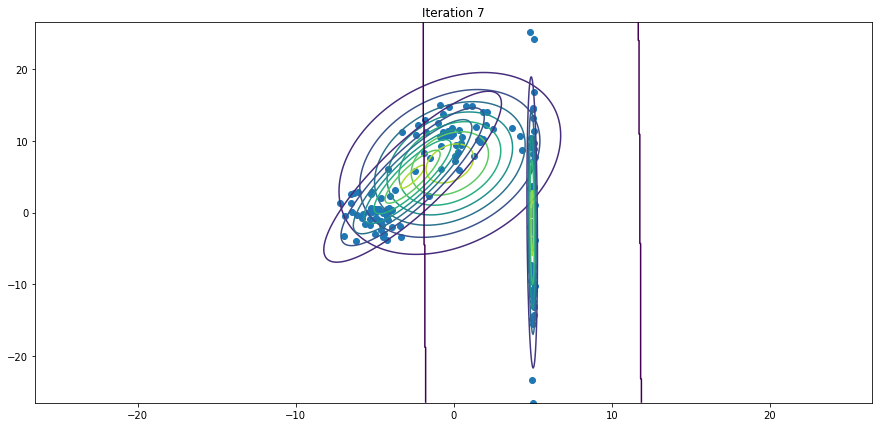

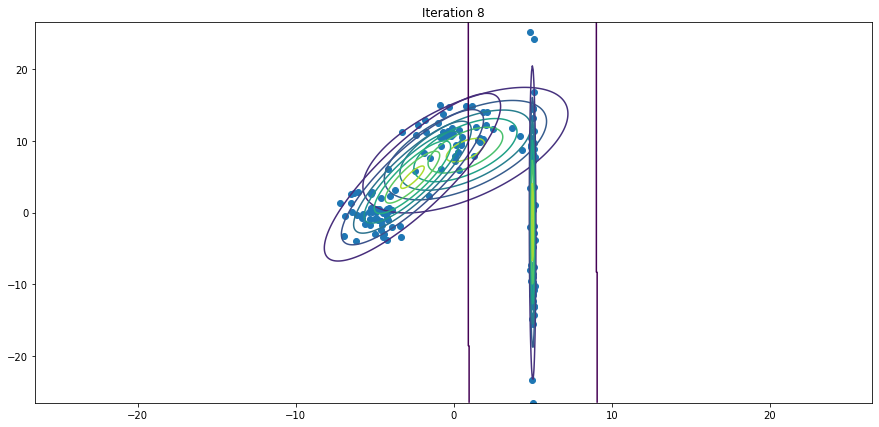

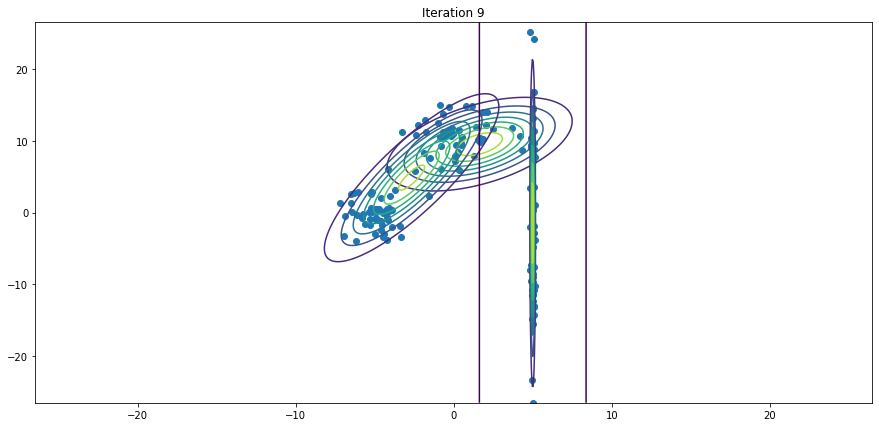

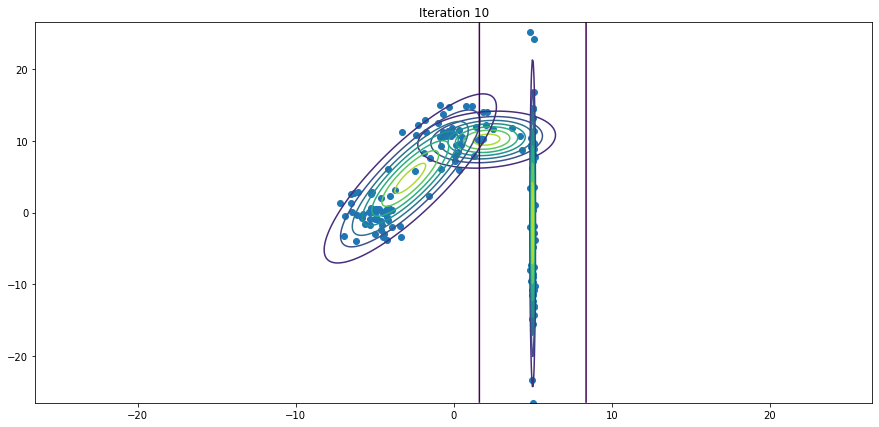

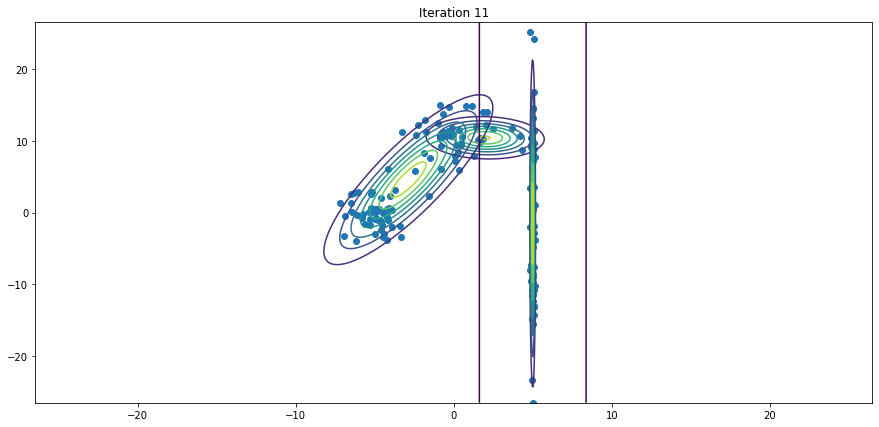

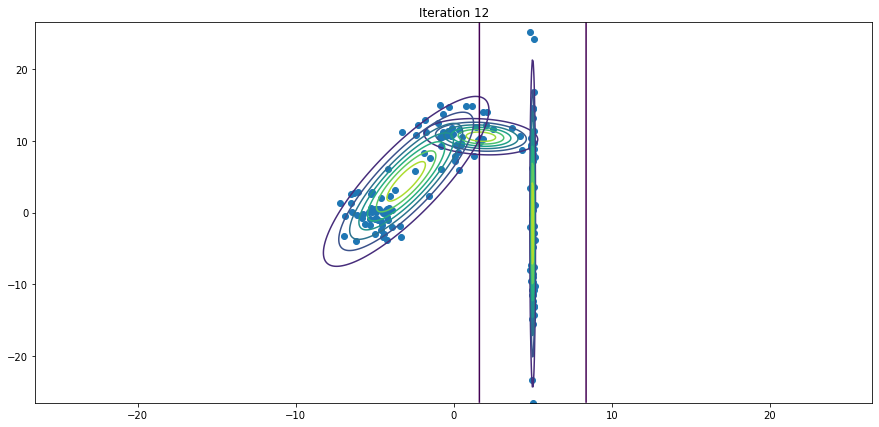

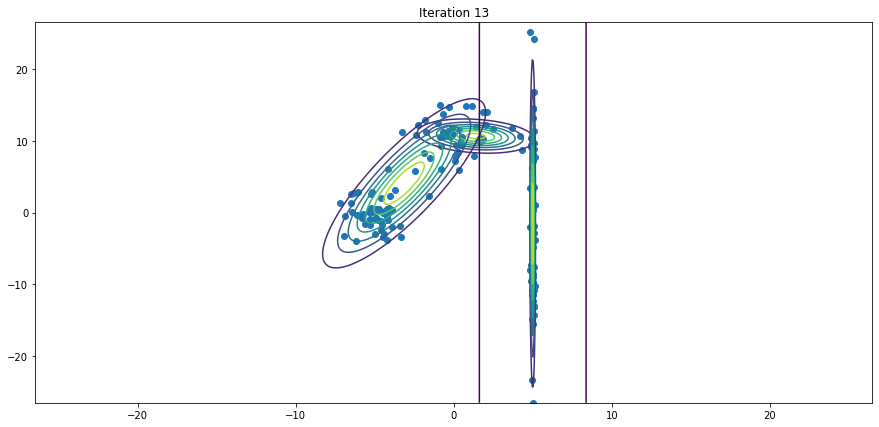

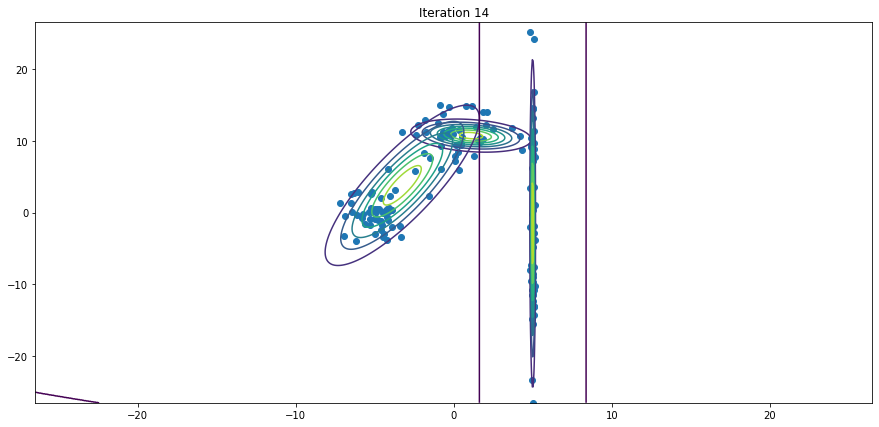

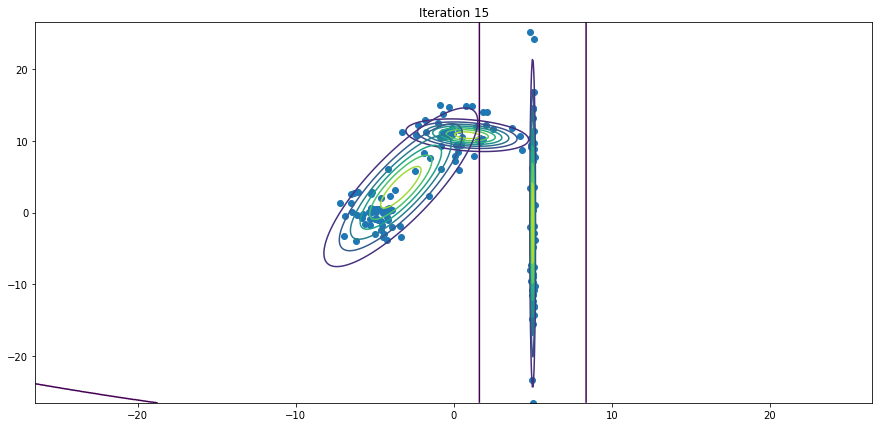

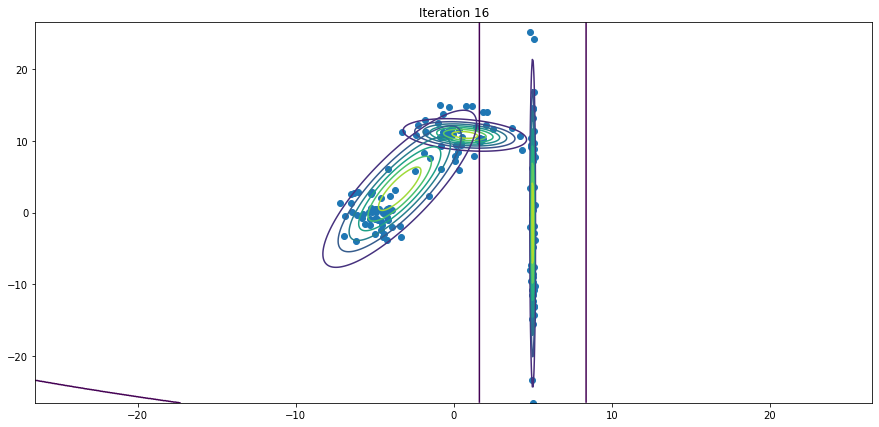

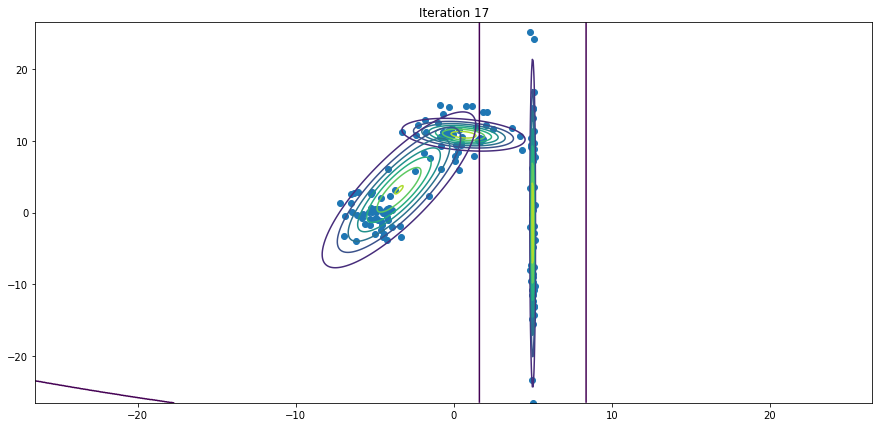

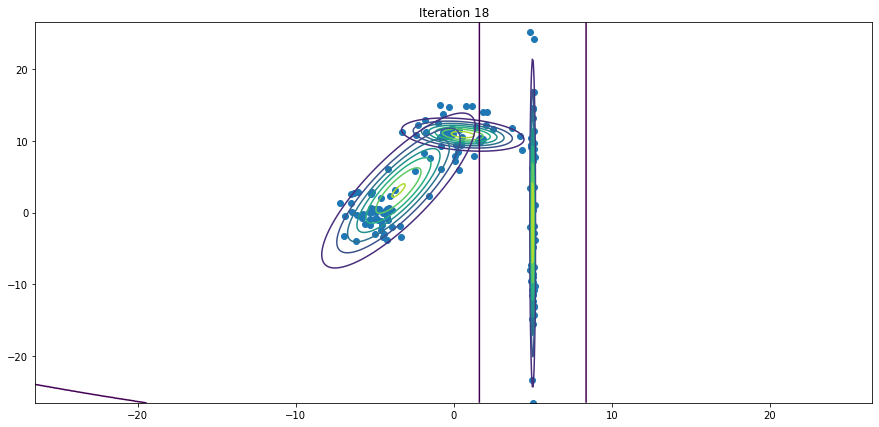

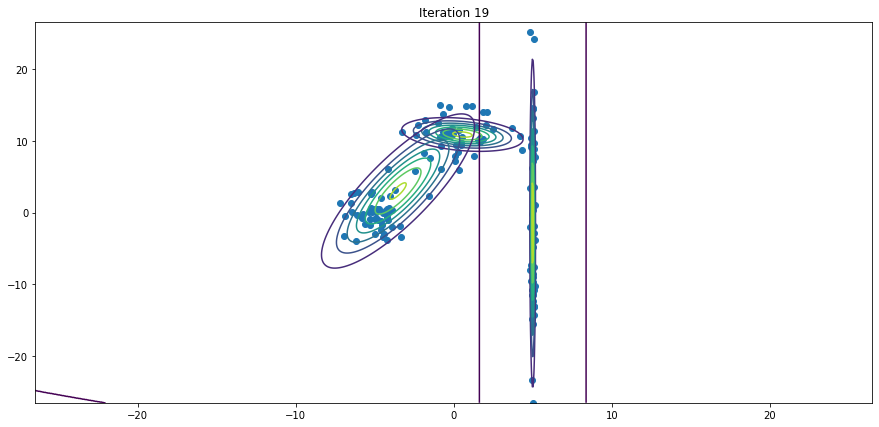

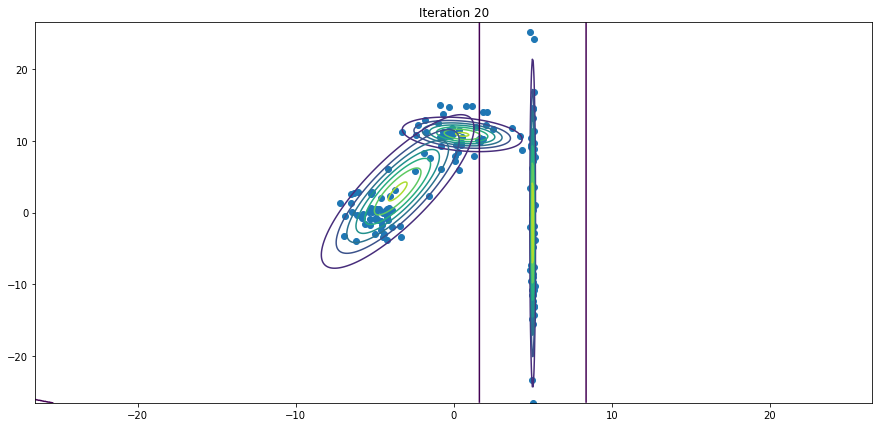

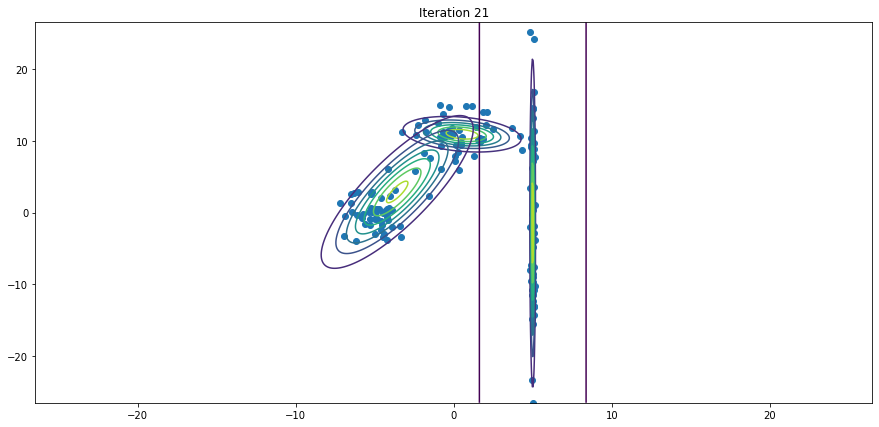

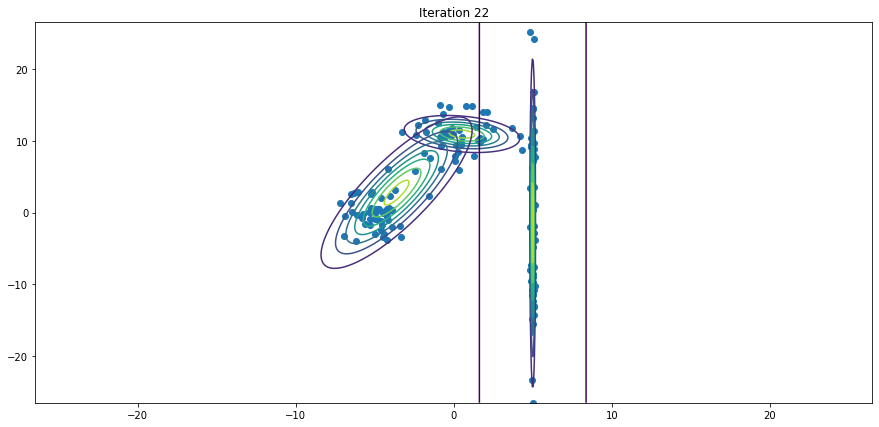

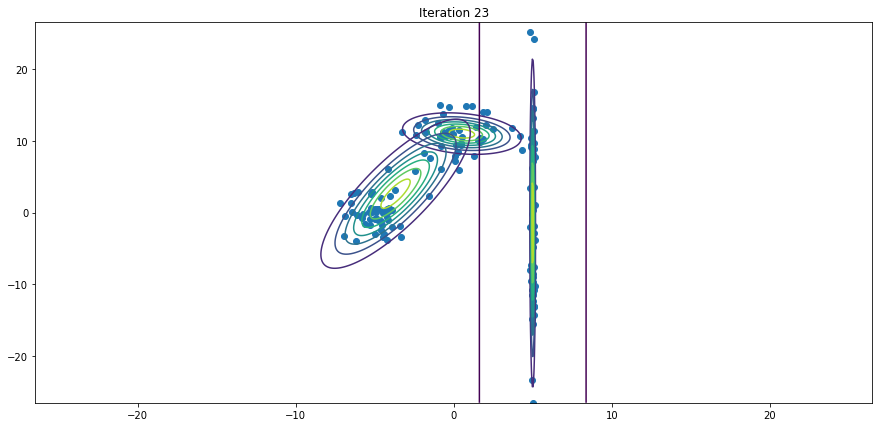

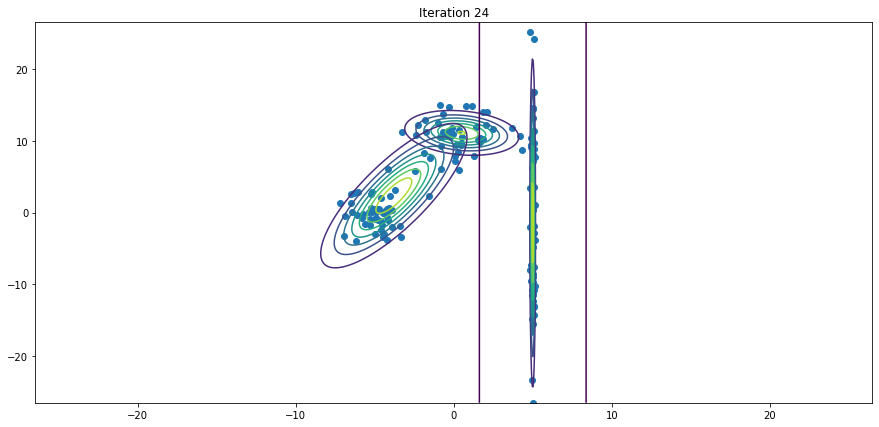

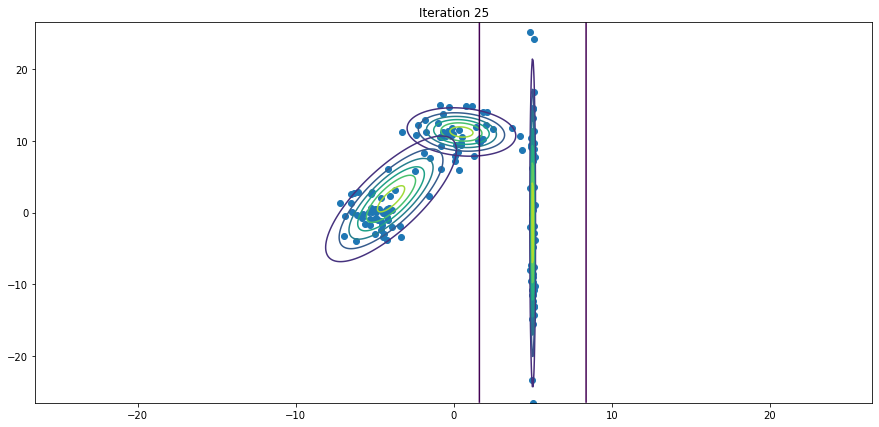

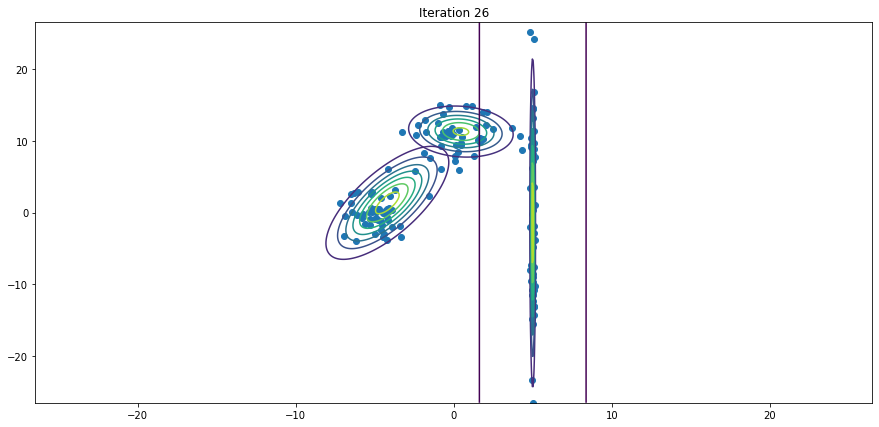

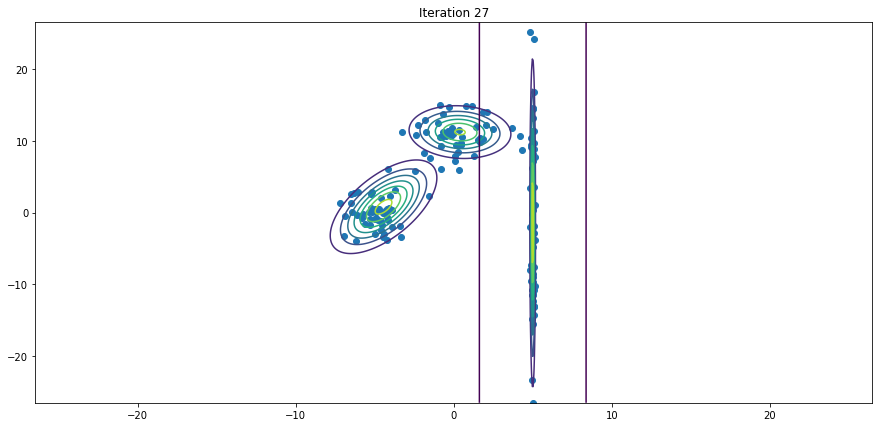

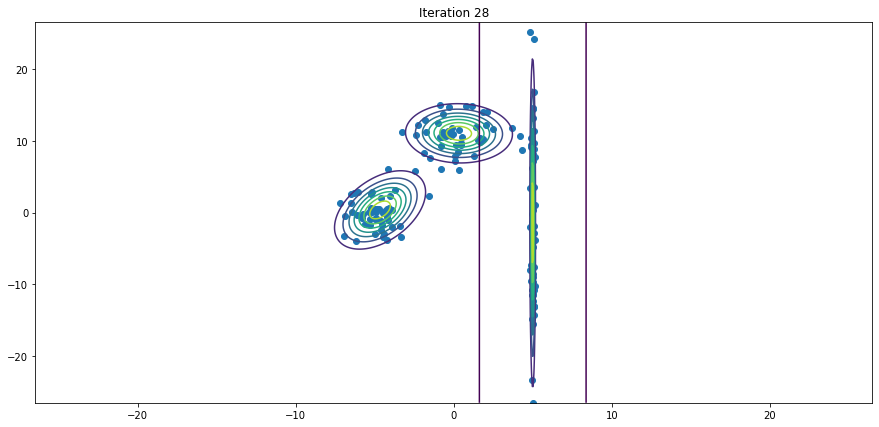

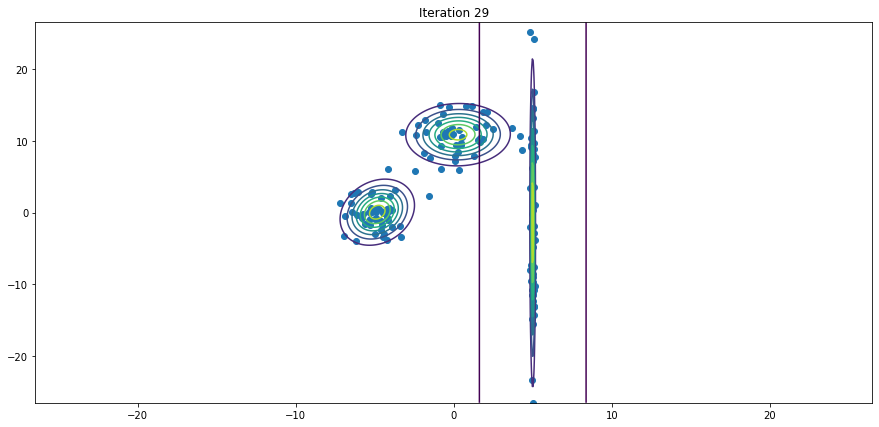

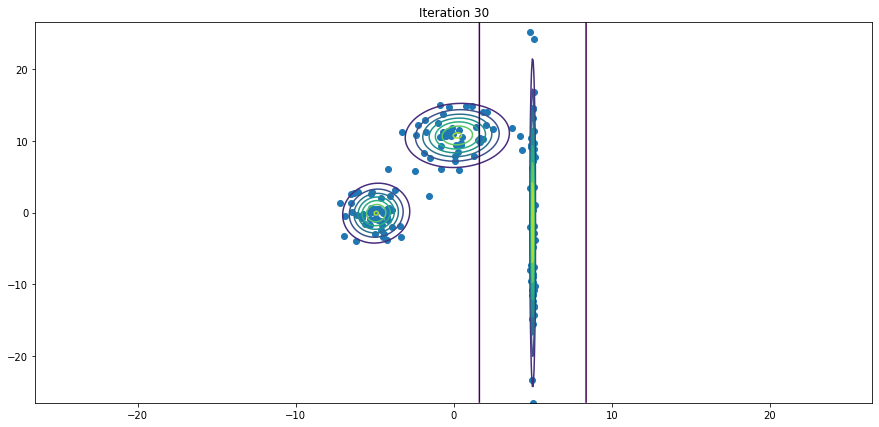

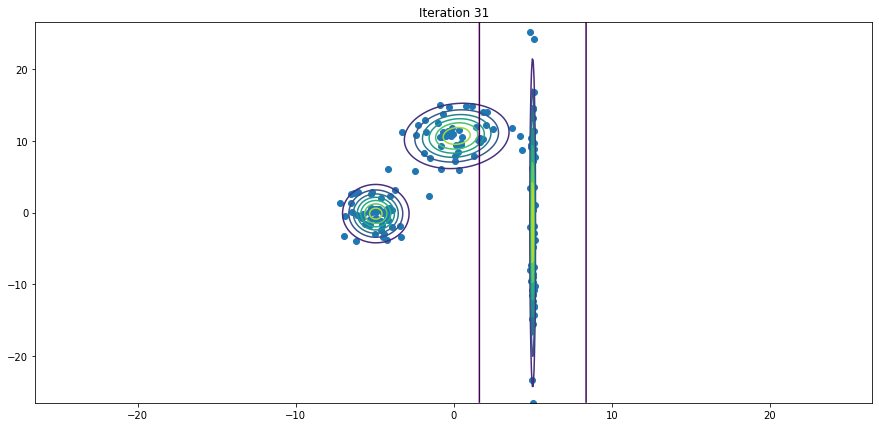

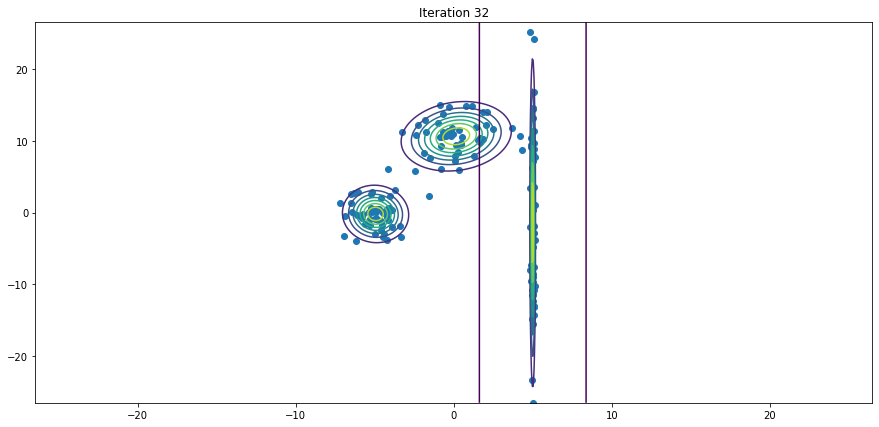

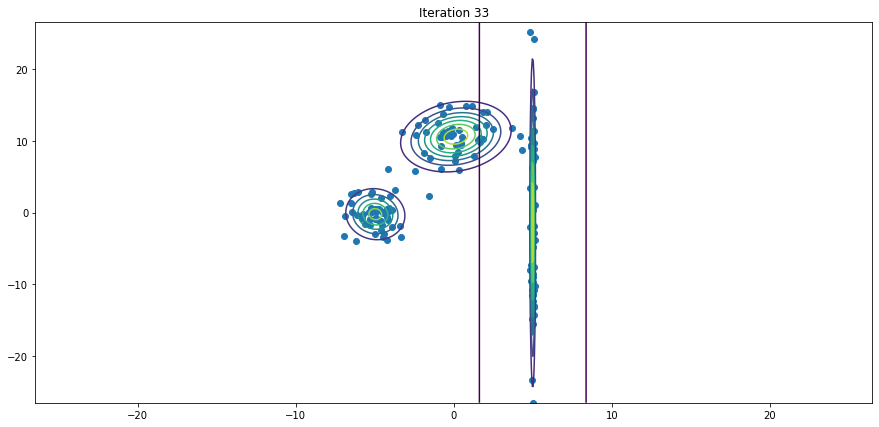

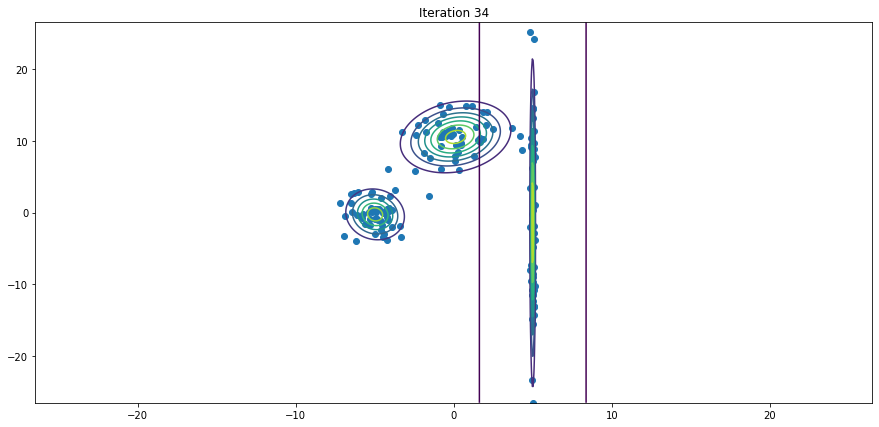

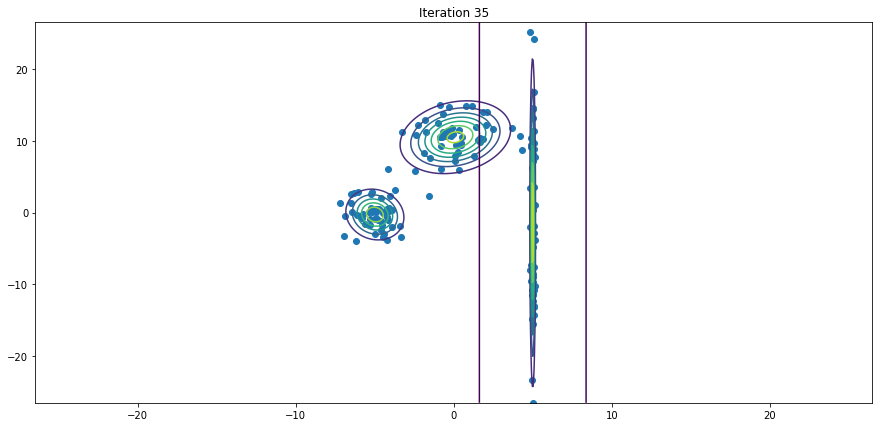

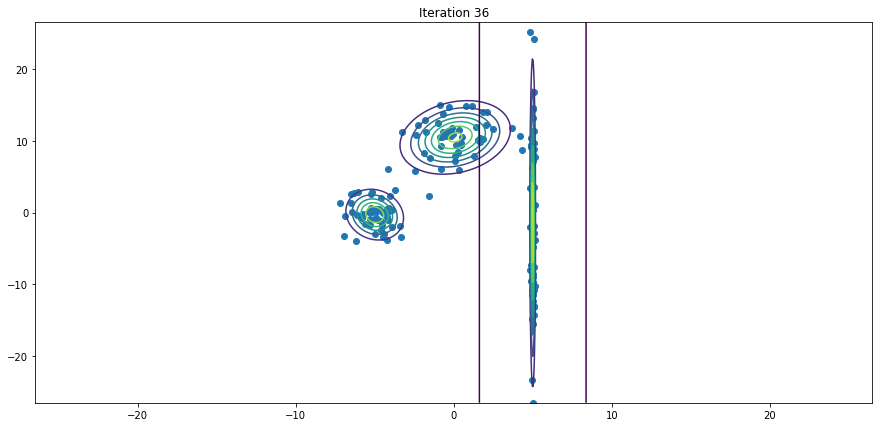

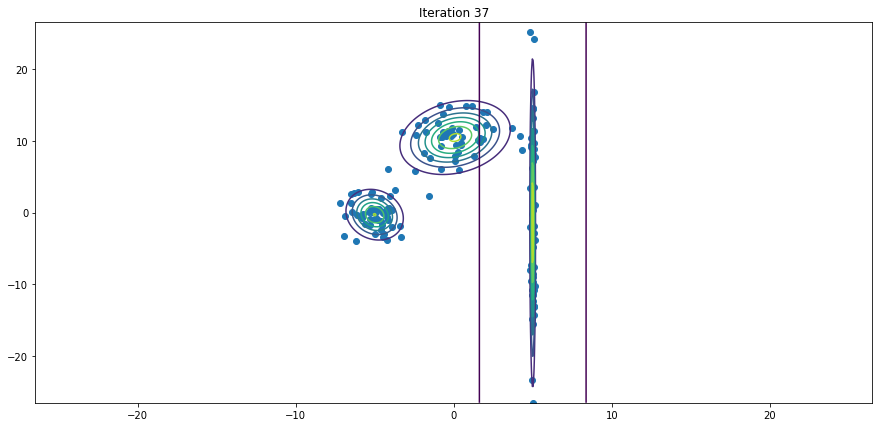

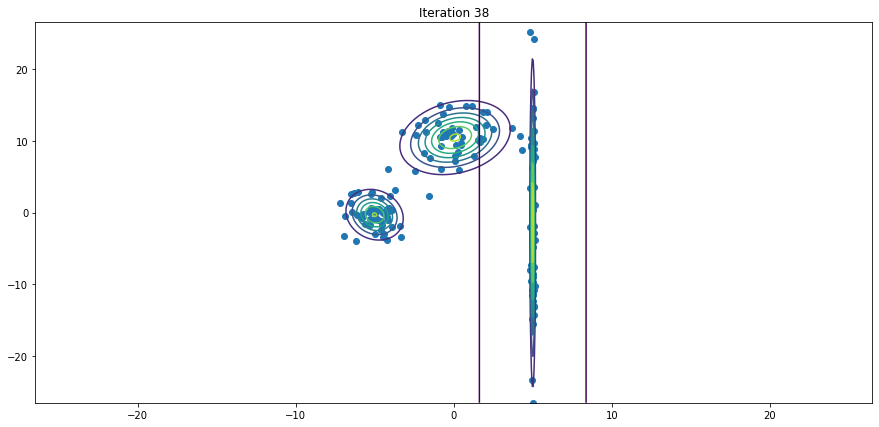

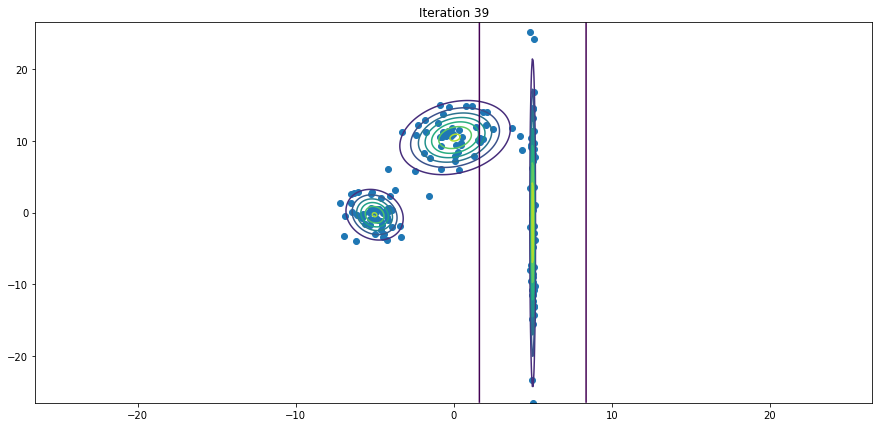

In [50]:
# Depending on your implementation this cell might take a while to run... (this is mainly due to the plots)
W, pi, means, covs, log_likelihood_train = run_EM_on_GMM(X, K, 150, plot_intermediate=True)

Text(0, 0.5, 'Log likelihood')

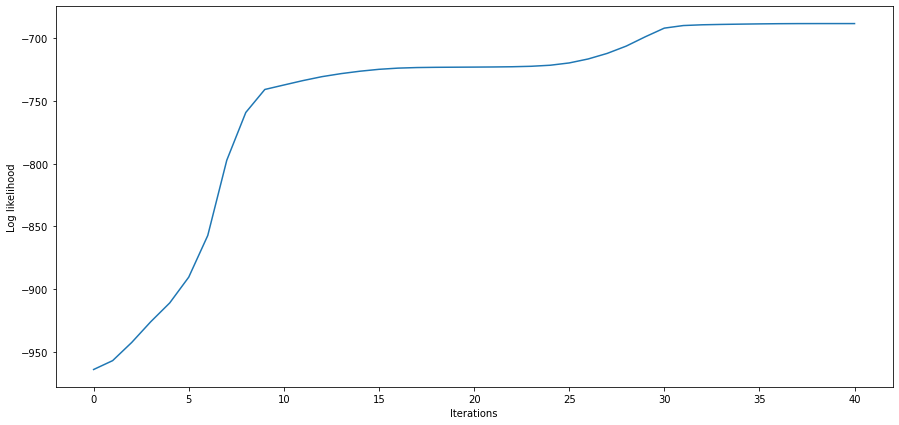

In [51]:
plt.figure(figsize=(15,7))
plt.plot(log_likelihood_train)
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

# TODO 7: explain the results you got (max 10 lines)

1-D dataset:
- Compare plots in to do 4 with the ones in to do 6, what has changed? Is EM providing us a meaningful clustering? 

2-D dataset:
- Why is the log likelihood monotonically increasing? Is this what you expect from the theory? Compare both log likelihood trajectory and 2-d plots.
- Is delta log likelihood monotonically going to zero?  
- Which termination criterion is met first?

(Answer in the next cell, no need to add code)

In [52]:
# YOUR CODE HERE
'''
1-D dataset:
I notice that the shape of the class-probability has changed, in particular in the TODO 6 the EM algorithm has modify: pi, mean and covariance of each class in order to find maximum likelihood estimate.
The clustering provide by the EM is usefull, now i can see the data splitted and assigned in this three clusters, then i have computed the classification without labels.
2-D dataset:
Like my expectations the log likelihood monotonically increase, this is beacause at each step I try to increase it: in the E_step I built a function 'Q' that is a lower bound of log likelihood while in the
M-step i maximize this new function that gives me new parameters that better perform the maximization of the log_likelihood, I repeat this procedur untill i will converge in a local maximum. I can confirm 
this observing both likelihood trajectory, but i also notice that in the 1D case the convergence is not clear: four jumps occurs, could be that another jump can happen after my algorithm has stopped, for
avoid this I could try with different initial guesses or without the delta log likelihood constrain.
In the 2-D plot I can observe that the convergence is more uniform but the delta log likelihood is not monotonically going to zero and ONLY at the lastest iterations have a similar trend. For the 1_D plot,
due to the 'jumps' definitely the delta log likelihood is not monotonically going to zero and I should check if other jumps occurs.
Both plots stop due to the value of delta log likelihood and by looking to the trajectory of the log-likelihood the 2-D probably reach its local maximum, in the other hand for the 1_D case I would like to
check without the delta constrain. I have repeated the EM and after 100 iterarions no jumps occurs, then I can state that also for this case we have reached up the local maximum.

'''

"\n1-D dataset:\nI notice that the shape of the class-probability has changed, in particular in the TODO 6 the EM algorithm has modify: pi, mean and covariance of each class in order to find maximum likelihood estimate.\nThe clustering provide by the EM is usefull, now i can see the data splitted and assigned in this three clusters, then i have computed the classification without labels.\n2-D dataset:\nLike my expectations the log likelihood monotonically increase, this is beacause at each step I try to increase it: in the E_step I built a function 'Q' that is a lower bound of log likelihood while in the\nM-step i maximize this new function that gives me new parameters that better perform the maximization of the log_likelihood, I repeat this procedur untill i will converge in a local maximum. I can confirm \nthis observing both likelihood trajectory, but i also notice that in the 1D case the convergence is not clear: four jumps occurs, could be that another jump can happen after my alg

In [53]:
# What is the effect of a wrong choice of the number of classes?
centers = [[-2, 0], [0, 3], [2, -1]]
X, Y = make_blobs(cluster_std=clusters_cov, centers=centers, random_state=20, n_samples=150, shuffle=True)

Ks = [2, 3, 4, 5, 6]
results = []
for k in Ks:
    results.append(run_EM_on_GMM(X, k, 150, plot_intermediate=False))

Iteration 0, log likelihood -800.4264,  delta log likelihood 0.8592
Iteration 1, log likelihood -799.2701,  delta log likelihood 1.1563
Iteration 2, log likelihood -796.9796,  delta log likelihood 2.2905
Iteration 3, log likelihood -794.0727,  delta log likelihood 2.9069
Iteration 4, log likelihood -792.2235,  delta log likelihood 1.8492
Iteration 5, log likelihood -791.1991,  delta log likelihood 1.0244
Iteration 6, log likelihood -790.4509,  delta log likelihood 0.7482
Iteration 7, log likelihood -789.7413,  delta log likelihood 0.7096
Iteration 8, log likelihood -788.9746,  delta log likelihood 0.7667
Iteration 9, log likelihood -788.0953,  delta log likelihood 0.8793
Iteration 10, log likelihood -787.0240,  delta log likelihood 1.0713
Iteration 11, log likelihood -785.5856,  delta log likelihood 1.4383
Iteration 12, log likelihood -783.3420,  delta log likelihood 2.2437
Iteration 13, log likelihood -779.0631,  delta log likelihood 4.2788
Iteration 14, log likelihood -769.4967,  del

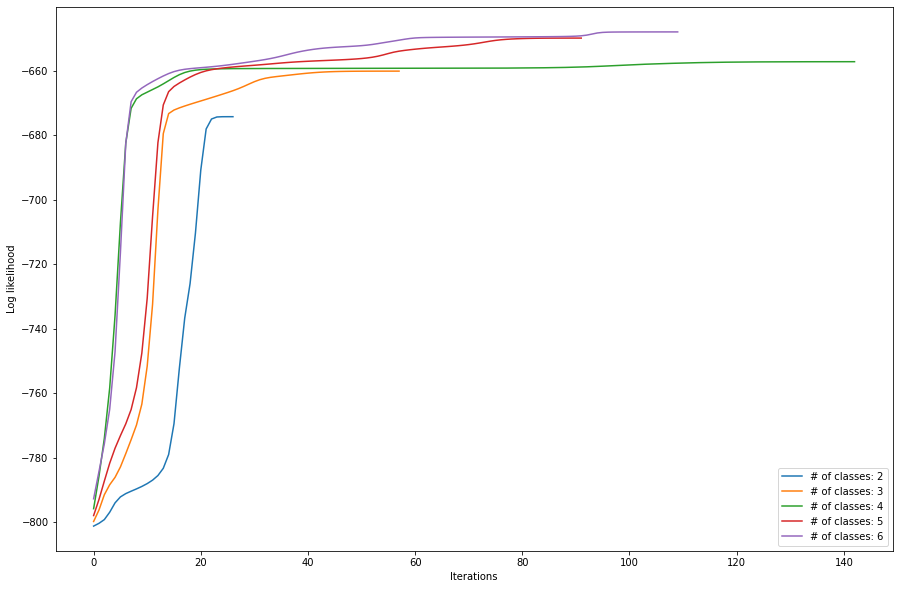

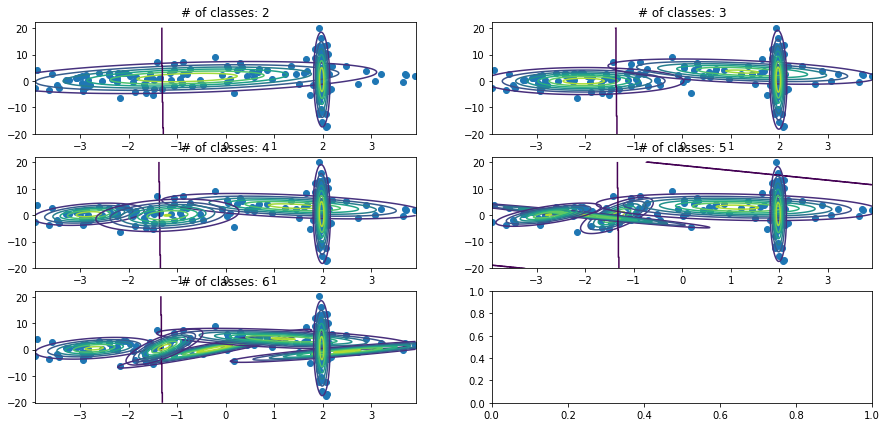

In [54]:
# Let's plot the log likelihood trajectories and the final 2-d Clustering
plt.figure(figsize=(15,10))
for res, k in zip(results, Ks): 
    plt.plot(np.array(res[-1]), label=f'# of classes: {k}')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Log likelihood')

x_max, y_max = np.max(np.abs(X[:,0])), np.max(np.abs(X[:,1]))
x, y = np.mgrid[-x_max:x_max:.01, -y_max:y_max:.01]
pos = np.dstack((x, y))

fig, axes = plt.subplots(3, 2, figsize=(15,7))
# Plot scatter plot of training data and corresponding clusters    
for (_, pi, means, covs, _), K, ax in zip(results, Ks, axes.reshape(-1,)): 
    for k in range(K):
        ax.contour(x, y, multivariate_normal(means[k], covs[k]).pdf(pos), )
    ax.scatter(X[0:,0], X[0:,1])
    ax.set_title(f'# of classes: {K}')

# MNIST clustering

Let's apply GMM to a slightly more complex dataset: MNIST. In the following we shall use the sklearn implementation of the EM. Once we fit the GMM we shall visualize the centers in order to evaluate whether the clustering algorithm came up with a meaningful solution (in an ideal scenario we'd expect to have each center representing one single digit).

In [55]:
from sklearn.datasets import fetch_openml
from sklearn.mixture import GaussianMixture

X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

from sklearn.model_selection import train_test_split

m_t = 5000
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=m_t/len(Y), random_state=ID_number, 
                                                    stratify=Y)

# Function to plot a digit and print the corresponding label
def plot_digit(vect_img, ax, cluster_id=None):
    ax.set_title(f'Cluster ID: {cluster_id}')
    ax.imshow(
        vect_img.reshape(28,28),
        cmap          = 'gray',
        interpolation = "nearest"
    )

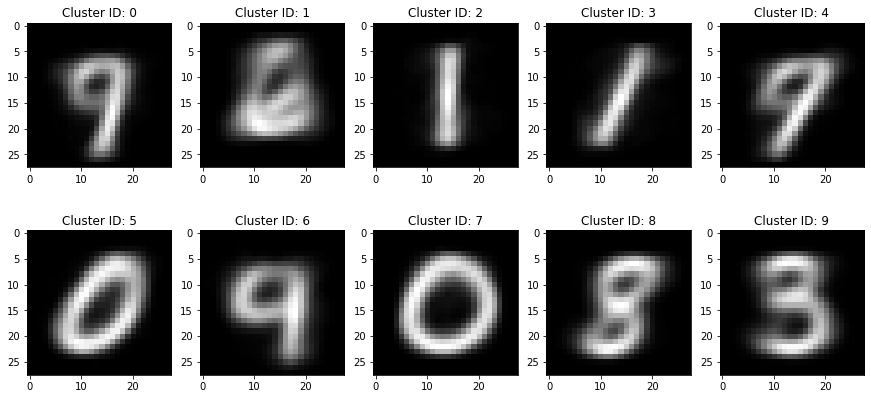

In [56]:
# TODO 8: use GaussianMixture from skelearn to cluster x_train and then predict the labels.
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

K = 10
# When you initialize the GaussianMixture object use set random_state=ID_number
gmm = None
gmm_pred = None
# YOUR CODE HERE
gmm = GaussianMixture(n_components=K, random_state=1167313).fit(x_train)
gmm_pred = gmm.predict(x_train)

plt, axes = plt.subplots(2, K // 2, figsize=(15,7))
for k, ax in zip(range(K), axes.reshape(-1,)):
    plot_digit(gmm.means_[k], ax, cluster_id=k)   

In [57]:
assert gmm_pred.shape == (m_t,)

# Comparison with supervised models: 
In the next cell we shall compare Unsupervised methods (Kmeans and GMM) with a
Supervised method (NNs) on MNIST. 
Note that supervised methods cannot be applied in the unsupervised setting (i.e. we do not have any label). 
Nonetheless we can apply an unsupervised method to a supervised problem (we just need to neglect the extra piece 
of information we have: the labels). 
In the following we shall train both Kmeans and GMM as if we do not have labels and then we shall compare their
predictions to the ground truth labels. 

NOTE: in an unsupervised scenario we are not able to compare model predictions with ground truth labels since 
labels are not part of the problem statement.

In [58]:
# TODO 9: 
# Remember in ANY unsupervised clustering algorithm the name of the cluster DOES NOT possess any meaning. 
# The first class of the GMM model trained on the MNIST dataset does not necessarily represent the digits "0". 
# You can see this on the previous plots (plots of the centers of each component).
# Therefore we need to find a way to convert model clusters (predicitons) to ground truth labels. Several choices 
# are possible, in the following we shall use a very simple and straightforward rule: 
# 1- Find all the indeces of the data belonging to the same cluster predicted by the clustering model
# 2- Use these indeces (in the dataset) to gather the true labels
# 3- Compute the mode on the choosen true labels
# 4- Assign the mode as the new name of the cluster.
# In this way we are able to compare model predictions with the true labels (ground truth labels) and we can 
# compute the number of missclassified examples (as we did in previous Classification HWs). 

from scipy.stats import mode
def convert_prediction_labels(targets : np.ndarray, predictions : np.ndarray, num_clusters : int) -> np.ndarray:
    '''
    Function to assign a different label to the predictions of a clustering algorithm. Use the 4 steps described 
    earlier.
    :param targets: True labels (of shape (N,))
    :param predictions: Labels predicted by the clustering algorithm (of shape (N,))
    :param num_clusters: # of clusters in the training dataset
    :returns: 
        pred_labels: new labels for each datum (of shape (N,))
    '''
    pred_labels = np.zeros_like(targets)
    for k in range(num_clusters):
        # YOUR CODE HERE
        indeces = np.argwhere(predictions == k).reshape((-1)) #Find all the indeces
        true_labels = targets[indeces]
        mod, count = mode(true_labels ) #compute mode
        pred_labels[indeces] = mod  #Assign the mode as the new name of the cluster
    
    x = np.count_nonzero(pred_labels == '9')
    return pred_labels

def compute_score(targets, predictions, num_clusters):
    pred_labels = convert_prediction_labels(targets, predictions, num_clusters)
    errors = sum(pred_labels == targets)
    return (1 - errors / len(targets))

In [59]:
assert convert_prediction_labels(y_train, gmm_pred, 10).shape == (m_t,)

In [ ]:
# TODO 10: Use sklearn GaussianMixture and KMeans to cluster x_train. Then evaluate the errors using the groud 
# truth labels (y_train) using the functions we built in the previous cell. Eventually we compare clustering 
# error rates with a supervised classification method: MLP.

# When you initialize the GaussianMixture and KMeans object use set random_state=ID_number
gmm, gmm_pred_train, gmm_pred_test = None, None, None
# YOUR CODE HERE
gmm = GaussianMixture(n_components=K, random_state=1167313).fit(x_train)
gmm_pred_train = gmm.predict(x_train)
gmm_pred_test = gmm.predict(x_test)
gmm_tr_err   = compute_score(y_train, gmm_pred_train, K)
gmm_test_err = compute_score(y_test, gmm_pred_test, K)
print(f'GMM Training err    {gmm_tr_err:.4f}, Test err {gmm_test_err:.4f}')


from sklearn.cluster import KMeans
kmeans, kmeans_pred_train, kmeans_pred_test = None, None, None
# YOUR CODE HERE
kmeans = KMeans(n_clusters=K, random_state=1167313).fit(x_train)
kmeans_pred_train = kmeans.predict(x_train)
kmeans_pred_test = kmeans.predict(x_test)
kmeans_tr_err   = compute_score(y_train, kmeans_pred_train, K)
kmeans_test_err = compute_score(y_test, kmeans_pred_test, K)
print(f'Kmeans Training err {kmeans_tr_err:.4f}, Test err {kmeans_test_err:.4f}')


from sklearn.neural_network import MLPClassifier
best_mlp_large = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, alpha=1e-4, solver='sgd', tol=1e-4, 
                               random_state=ID_number, learning_rate_init=.1)
best_mlp_large.fit(x_train, y_train)
training_error = 1. - best_mlp_large.score(x_train, y_train)
test_error = 1. - best_mlp_large.score(x_test, y_test)

print(f'MLP Training err    {training_error:.4f}, Test err {test_error:.4f}')

In [ ]:
assert gmm_pred_train.shape == (m_t,)
assert gmm_pred_test.shape == (70000 - m_t,)
assert kmeans_pred_train.shape == (m_t,)
assert kmeans_pred_test.shape == (70000 - m_t,)

# TODO 11 (max 10 lines)
- What is the effect of a wrong choice of the number of clusters? Briefly describe both log likelihood as a function of iterations and optimal clustering (depicted on the 2-D plot). 
- The number of errors using GMM on MNIST is quite high, could have you predicted such a behaviour looking only at the center clusters visualized in to do 8? Why?
- Compare GMM, Kmeans and NN. Which is the best model? Why? Did you expect the result?


(Answer in the next cell, no need to add code)

In [ ]:
# YOUR CODE HERE
'''
1) The number of clusters depends on the distribution of points in a dataset and the desired clustering resolution of the user, usually it is choose a balance between the compression of the data (using a
single cluster), and the accuracy (assign each data to a cluster). Therefore, if we increase the number of cluster, as in the plot, we will have more freedome to allocate each data and have a less error.
I can observe this by noticing that log likelihood increase with the number of cluster, but we pay the price of complexity increasing and therefore for reach the local maxima i will need more iteration.

2)Yes, the initial clusters centers are only in the numbers: 0,1,3,8,9 and so the pred_labels of TODO 9 never assign some number(ex:2 and 5) a better choice could be one center for each digit. 

3) From the train and test errors the best model is the NN, like my expectationa,  follow Kmeans and at last GMM. NN is a supervised method and we have performed multiclassification (we know the input
label) and not clustering, then it is a different problem in which we haven't the help of class labels. GMM and Kmeans are both unsupervised method, in fact they have similar performances, but have some
differences: in the Kmean the clustering is performed by Hard Assignment (We are certan that the points belong to a particular cluster), while GMM uses probability of a sample to determine whether it
belonging to a cluster.
'''

